In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle

In [8]:
df = pd.read_csv('train.csv')

In [9]:
df

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [13]:
df.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [15]:
df.TWF.unique()

array([0, 1], dtype=int64)

In [18]:
df.shape

(136429, 14)

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,136429.0,68214.000000,39383.804275,0.0,34107.0,68214.0,102321.0,136428.0
Air temperature [K],136429.0,299.862776,1.862247,295.3,298.3,300.0,301.2,304.4
Process temperature [K],136429.0,309.941070,1.385173,305.8,308.7,310.0,310.9,313.8
Rotational speed [rpm],136429.0,1520.331110,138.736632,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],136429.0,40.348643,8.502229,3.8,34.6,40.4,46.1,76.6
Tool wear [min],136429.0,104.408901,63.965040,0.0,48.0,106.0,159.0,253.0
Machine failure,136429.0,0.015744,0.124486,0.0,0.0,0.0,0.0,1.0
TWF,136429.0,0.001554,0.039389,0.0,0.0,0.0,0.0,1.0
HDF,136429.0,0.005160,0.071649,0.0,0.0,0.0,0.0,1.0
PWF,136429.0,0.002397,0.048899,0.0,0.0,0.0,0.0,1.0


In [24]:
df.loc[:,"RNF"].value_counts()

RNF
0    136121
1       308
Name: count, dtype: int64

In [25]:
df[df.loc[:,"Machine failure"]==1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].apply(pd.value_counts)

,TWF,HDF,PWF,OSF,RNF
0,1936,1450,1824,1612,2142
1,212,698,324,536,6


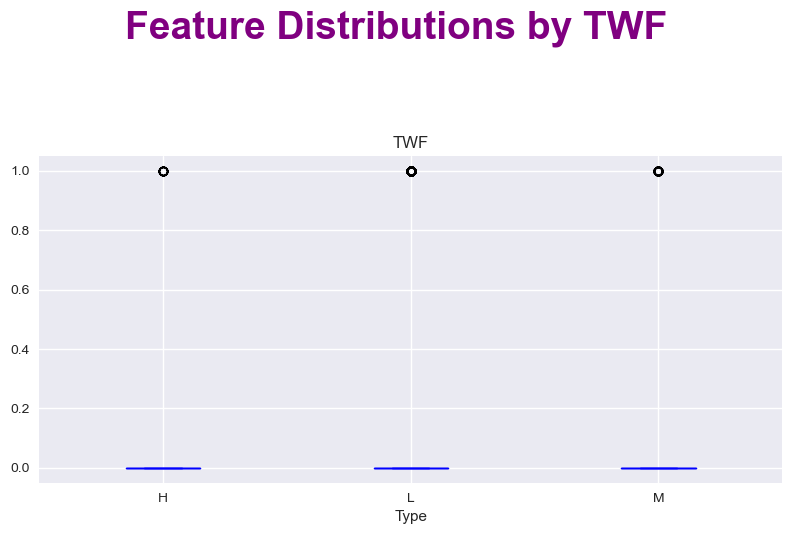

In [64]:
fig, ax = plt.subplots()
df.boxplot(column='TWF', by='Type', color='blue', ax=ax)

fig.suptitle(f'Feature Distributions by TWF\n\n', ha='center', fontweight='bold', color='purple', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

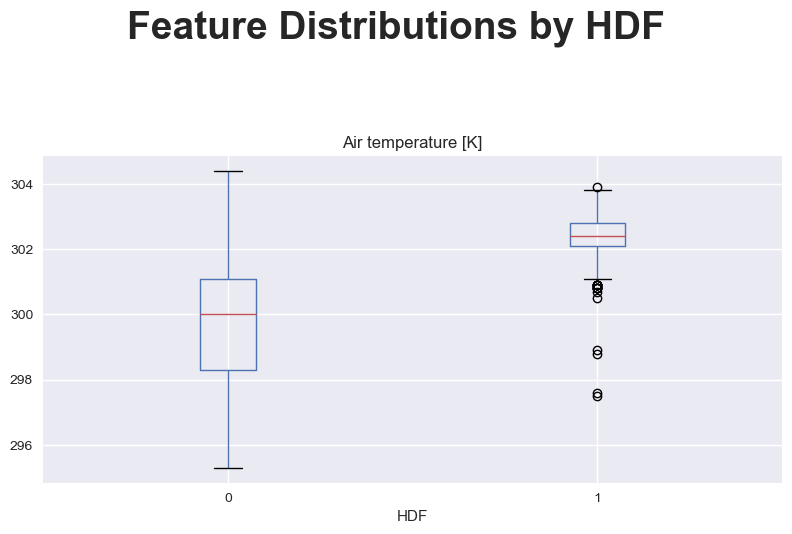

In [66]:
fig, ax = plt.subplots()
df.boxplot(column='Air temperature [K]', by='HDF', ax=ax)

fig.suptitle(f'Feature Distributions by HDF\n\n', ha='center', fontweight='bold', fontsize=28, y=0.96)
plt.tight_layout(pad=1.0)
plt.show()

In [46]:
fig, ax = plt.subplots(n_rows, 3, figsize=(20, 6 * n_rows))
ax = ax.ravel()

unique_target = df['TWF'].unique()
n_categories = len(unique_target)
colors = sns.color_palette(c, n_categories)

for i, column in enumerate(columns):
    data = [df[df['TWF'] == target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
  
    ax[i].set_title(f'{column} Distribution', fontsize=22)
    ax[i].set_xlabel(None, fontsize=18)
    ax[i].set_ylabel(None, fontsize=18)



NameError: name 'c' is not defined

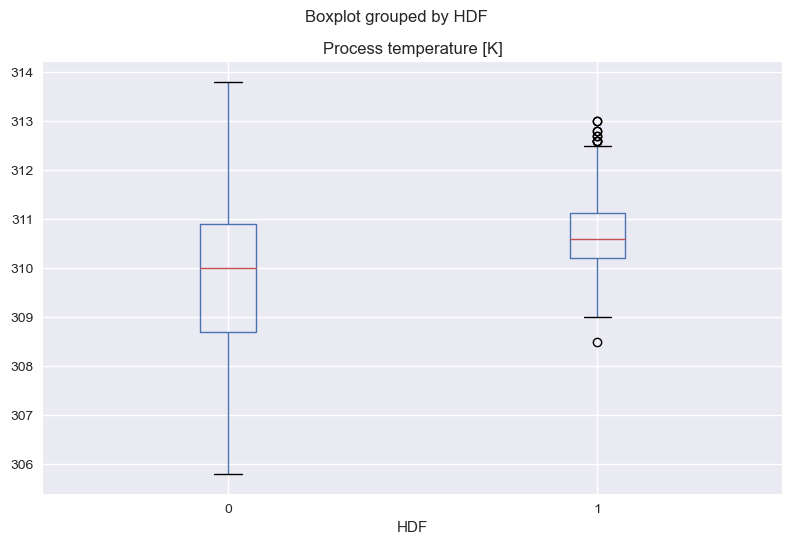

In [68]:
fig, ax = plt.subplots()
df.boxplot(column='Process temperature [K]', by='HDF', ax=ax)

plt.tight_layout(pad=1.0)
plt.show()

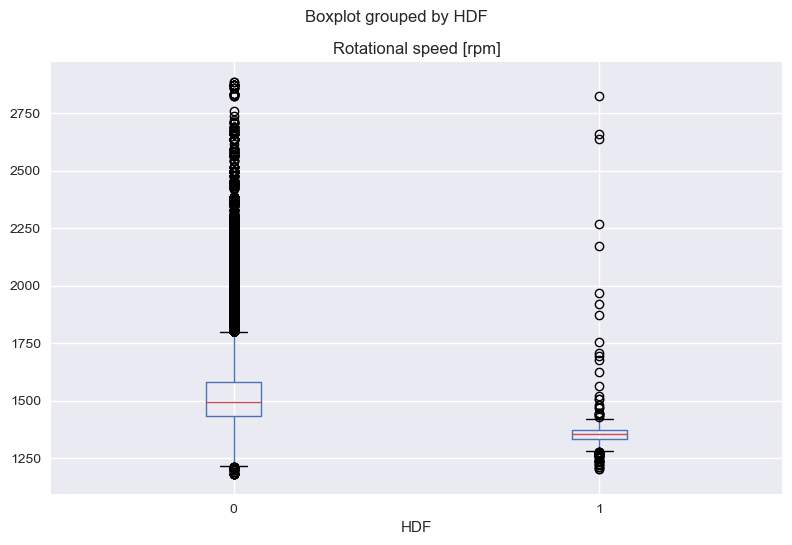

In [69]:
fig, ax = plt.subplots()
df.boxplot(column='Rotational speed [rpm]', by='HDF', ax=ax)

plt.tight_layout(pad=1.0)
plt.show()

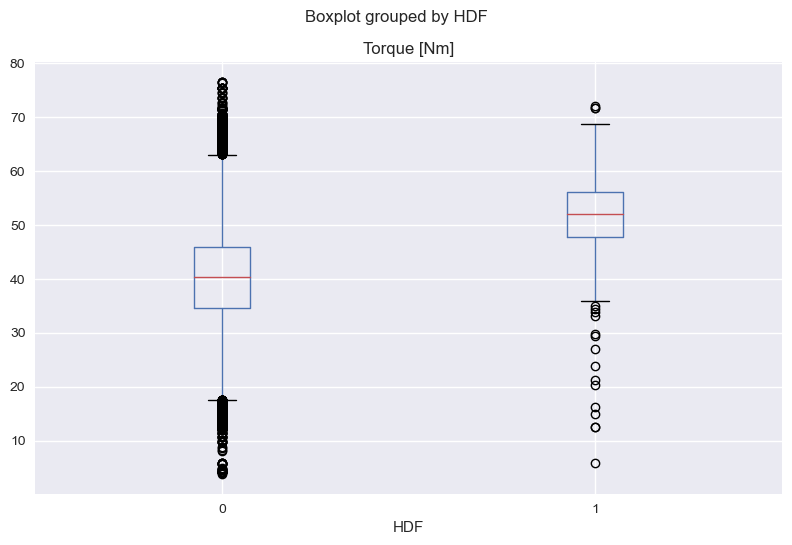

In [70]:
fig, ax = plt.subplots()
df.boxplot(column='Torque [Nm]', by='HDF', ax=ax)

plt.tight_layout(pad=1.0)
plt.show()

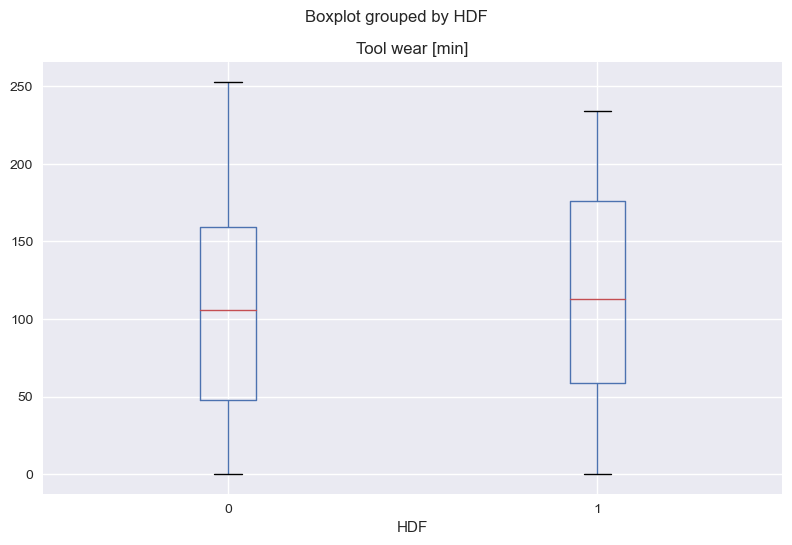

In [71]:
fig, ax = plt.subplots()
df.boxplot(column='Tool wear [min]', by='HDF', ax=ax)

plt.tight_layout(pad=1.0)
plt.show()